# XAI Project for signature classification using CEDAR dataset

## Configurations Colab & Kaggle API

In [1]:
!git clone https://github.com/silvano315/eXplainability-for-signature-detection.git

Cloning into 'eXplainability-for-signature-detection'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 125 (delta 65), reused 83 (delta 28), pack-reused 0 (from 0)
Receiving objects: 100% (125/125), 65.49 KiB | 2.42 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [2]:
import os

os.chdir("eXplainability-for-signature-detection")
os.getcwd()

'/content/eXplainability-for-signature-detection'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Move your Kaggle API to /root/.config/kaggle and /root/.kaggle/kaggle.json

os.makedirs('/root/.kaggle', exist_ok = True)

!cp /content/drive/MyDrive/Kaggle_api/kaggle.json /root/.config/kaggle.json
!cp /content/drive/MyDrive/Kaggle_api/kaggle.json /root/.kaggle/kaggle.json

## Import libraries

In [5]:
import json
import logging
import yaml
import torch
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from src.utils.kaggle_downloader import setup_dataset
from src.utils.logger_setup import get_logger
from src.utils.dataset_analyzer import create_dataset_metadata, validate_dataset_consistency, \
                                        save_metadata, load_metadata
from src.utils.eda import print_dataset_statistics, plot_dataset_distribution, \
                            show_sample_images, analyze_image_properties, generate_eda_report
from src.data.cedar_dataset import CEDARDataset, create_dataloaders, create_balanced_splits
from src.model.model_factory import get_available_models, validate_model_config, create_model
from src.training.experiment import Experiment
from src.training.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from src.training.trainer import ModelTrainer
from src.visualization.plot_results import scatter_plot_metrics, plot_confusion_matrix, plot_misclassified_images

## Configurations

In [6]:
# Load config

with open('config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [7]:
# Setup paths

DATA_PATH = Path(config['paths']['data']['raw_path'])
MODELS_PATH = Path(config['paths']['data']['models_path'])
MODELS_PATH.mkdir(parents=True, exist_ok=True)

In [8]:
# Training parameters

BATCH_SIZE = config['training']['batch_size']
NUM_EPOCHS = config['training']['num_epochs']
LEARNING_RATE = config['training']['learning_rate']
NUM_CLASSES = config['dataset']['num_classes']

## Load data

In [9]:
# Download Malimg dataset from Kaggle

dataset_path = setup_dataset()
print(f"Dataset found at: {dataset_path}")

2025-07-28 09:12:05,348 - KaggleDataDownloader - INFO - Downloading dataset: shreelakshmigp/cedardataset
INFO:KaggleDataDownloader:Downloading dataset: shreelakshmigp/cedardataset


Dataset URL: https://www.kaggle.com/datasets/shreelakshmigp/cedardataset


2025-07-28 09:12:15,726 - KaggleDataDownloader - INFO - Dataset downloaded successfully to data/raw/cedardataset
INFO:KaggleDataDownloader:Dataset downloaded successfully to data/raw/cedardataset
2025-07-28 09:12:15,728 - KaggleDataDownloader - INFO - Starting dataset validation...
INFO:KaggleDataDownloader:Starting dataset validation...
2025-07-28 09:12:15,733 - KaggleDataDownloader - INFO - Readme content:
There are two folders

1. full_forg: Contains 1320 forgery signatures (24 forgeries for each of 55 writers).
2. full_org: Contains 1320 genuine signatures (24 genuines for each of 55 writers). 
INFO:KaggleDataDownloader:Readme content:
There are two folders

1. full_forg: Contains 1320 forgery signatures (24 forgeries for each of 55 writers).
2. full_org: Contains 1320 genuine signatures (24 genuines for each of 55 writers). 
2025-07-28 09:12:15,735 - KaggleDataDownloader - INFO - Dataset validation successful
INFO:KaggleDataDownloader:Dataset validation successful
2025-07-28 09:12

Dataset found at: data/raw/cedardataset


In [ ]:
# Generate metadata for the dataset

signatures_path = Path("data/raw/cedardataset/signatures")
metadata = create_dataset_metadata(signatures_path)

In [ ]:
# Save or load metadata with FLAG

SAVE_METADATA = False
dataset_metadata_path = Path("metadata/metadata.json")

if SAVE_METADATA:
    save_metadata(metadata, dataset_metadata_path)
else:
    metadata = load_metadata(dataset_metadata_path)

In [ ]:
# Validate dataset consistency (statistics, class distribution, etc.)

validate_metadata = validate_dataset_consistency(metadata)
for key, value in validate_metadata.items():
    if isinstance(value, dict):
        print(f"{key}:")
        for subkey, subvalue in value.items():
            print(f"  {subkey}: {subvalue}")
    else:
      print(f"{key}: {value}")

## Exploratory Data Analysis

In [ ]:
# Print a complete EDA report

signatures_path = Path("data/raw/cedardataset/signatures")
output_dir = Path("reports/eda")

generate_eda_report(signatures_path, metadata, output_dir)

In [ ]:
# I you want to run the EDA report step by step

print_dataset_statistics(metadata)

In [ ]:
# I you want to run the EDA report step by step

plot_dataset_distribution(metadata)

## Create Data Loaders

In [10]:
# If you haven't run it before

dataset_metadata_path = Path("metadata/metadata.json")

metadata = load_metadata(dataset_metadata_path)

2025-07-28 09:12:15,749 - training - INFO - Metadata loaded from: metadata/metadata.json
2025-07-28 09:12:15,749 - training - INFO - Metadata loaded from: metadata/metadata.json
2025-07-28 09:12:15,749 - training - INFO - Metadata loaded from: metadata/metadata.json
INFO:training:Metadata loaded from: metadata/metadata.json


In [11]:
# Update metadata with balanced splits

metadata_with_splits = create_balanced_splits(metadata)

print("\n")
print("You can see the split key updated")
for i, (key, value) in enumerate(metadata_with_splits.items()):
    print(f"{key}: {value}")
    if i == 5:
      break

2025-07-28 09:12:15,756 - training - INFO - Creating balanced splits for signature verification...
2025-07-28 09:12:15,756 - training - INFO - Creating balanced splits for signature verification...
2025-07-28 09:12:15,756 - training - INFO - Creating balanced splits for signature verification...
INFO:training:Creating balanced splits for signature verification...
2025-07-28 09:12:15,760 - training - INFO - Found 1320 original and 1320 forged signatures
2025-07-28 09:12:15,760 - training - INFO - Found 1320 original and 1320 forged signatures
2025-07-28 09:12:15,760 - training - INFO - Found 1320 original and 1320 forged signatures
INFO:training:Found 1320 original and 1320 forged signatures
2025-07-28 09:12:15,765 - training - INFO - Split distribution:
2025-07-28 09:12:15,765 - training - INFO - Split distribution:
2025-07-28 09:12:15,765 - training - INFO - Split distribution:
INFO:training:Split distribution:
2025-07-28 09:12:15,768 - training - INFO -   train: 1846 images (original



You can see the split key updated
original_43_16.png: {'type': 'original', 'subject_id': 43, 'sample_id': 16, 'split': 'train'}
original_10_9.png: {'type': 'original', 'subject_id': 10, 'sample_id': 9, 'split': 'test'}
original_18_12.png: {'type': 'original', 'subject_id': 18, 'sample_id': 12, 'split': 'train'}
original_3_10.png: {'type': 'original', 'subject_id': 3, 'sample_id': 10, 'split': 'val'}
original_9_11.png: {'type': 'original', 'subject_id': 9, 'sample_id': 11, 'split': 'val'}
original_50_19.png: {'type': 'original', 'subject_id': 50, 'sample_id': 19, 'split': 'train'}


In [12]:
# Create dataloaders for training, validation, and test sets

data_path = Path("data/raw/cedardataset/signatures")

dataloaders = create_dataloaders(data_path, metadata_with_splits)

2025-07-28 09:12:15,786 - training - INFO - Creating dataloaders...
2025-07-28 09:12:15,786 - training - INFO - Creating dataloaders...
2025-07-28 09:12:15,786 - training - INFO - Creating dataloaders...
INFO:training:Creating dataloaders...
2025-07-28 09:12:15,793 - training - INFO - Dataset initialized: 1846 images (split: train)
2025-07-28 09:12:15,793 - training - INFO - Dataset initialized: 1846 images (split: train)
2025-07-28 09:12:15,793 - training - INFO - Dataset initialized: 1846 images (split: train)
INFO:training:Dataset initialized: 1846 images (split: train)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/fre

In [14]:
# You can check the dataloaders for each split

for split, loader in dataloaders.items():
    print(f"{split} DataLoader:")
    for i, (images, labels) in enumerate(loader):
        print(f"  Batch {i+1}: {len(images)} images")
        print(f"  Labels: {labels}")
        print(f"  Images shape: {images.shape}")
        if i == 2:
            break
    print("\n")
    print(f"Class counts: {loader.dataset.get_class_counts()}")
    print(f"Subject info: {loader.dataset.get_subject_info()}")

train DataLoader:
  Batch 1: 32 images
  Labels: tensor([0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 1, 1, 1, 1])
  Images shape: torch.Size([32, 3, 224, 224])
  Batch 2: 32 images
  Labels: tensor([0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 0])
  Images shape: torch.Size([32, 3, 224, 224])
  Batch 3: 32 images
  Labels: tensor([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 1])
  Images shape: torch.Size([32, 3, 224, 224])


Class counts: {'original': 923, 'forgeries': 923}
Subject info: {'unique_subjects': 55, 'subject_ids': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]}
val DataLoader:
  Batch 1: 32 images
  Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Model Definition & Setup Training

In [25]:
# Model configuration --> Baseline model

model_config = {
    'type': 'baseline',
    'num_classes': 2,
    'input_channels': 3
}

In [ ]:
# Model configuration --> Transfer learning model

model_config = {
    'type': 'transfer',
    'model_name': 'resnet50',
    'num_classes': NUM_CLASSES,
    'pretrained': True,
    'use_custom_classifier': True
}

In [ ]:
# Give a look at every avialable model

get_available_models()

In [26]:
# Validate configuration

validate_model_config(model_config)

In [27]:
# Create model

model = create_model(model_config)

In [28]:
# Optimizer e Loss

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE
)

criterion = torch.nn.CrossEntropyLoss()

In [29]:
# Setup experiment

logger = get_logger()

experiment = Experiment(
    name="signature_detection_baseline_v1",       # maybe use the name of the model
    root="/content/drive/MyDrive/XAI_ProfAI/experiments",
    logger=logger
)
experiment.init()

2025-07-28 09:14:47,532 - training - INFO - Creating new experiment
2025-07-28 09:14:47,532 - training - INFO - Creating new experiment
2025-07-28 09:14:47,532 - training - INFO - Creating new experiment
2025-07-28 09:14:47,532 - training - INFO - Creating new experiment
2025-07-28 09:14:47,532 - training - INFO - Creating new experiment
INFO:training:Creating new experiment


In [30]:
# Setup callbacks

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=config['training']['early_stopping']['patience'],
        min_delta=config['training']['early_stopping']['min_delta'],
        verbose=True
    ),
    ModelCheckpoint(
        filepath='best_baseline_model.pth',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        optimizer=optimizer,
        mode='min',
        patience=5,
        factor=0.1,
        verbose=True
    )
]

In [31]:
# Initialize trainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

trainer = ModelTrainer(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    experiment=experiment,
    device=device,
    logger=logger
)

Using device: cuda


In [32]:
# Train the model

trained_model = trainer.train(
    train_loader=dataloaders['train'],
    val_loader=dataloaders['val'],
    num_epochs=NUM_EPOCHS,
    callbacks=callbacks
)

torch.save(trained_model.state_dict(), experiment.root / 'final_model_resnet_v1.pth')

2025-07-28 09:14:54,531 - training - INFO - Start training for 50 epoche
2025-07-28 09:14:54,531 - training - INFO - Start training for 50 epoche
2025-07-28 09:14:54,531 - training - INFO - Start training for 50 epoche
2025-07-28 09:14:54,531 - training - INFO - Start training for 50 epoche
2025-07-28 09:14:54,531 - training - INFO - Start training for 50 epoche
INFO:training:Start training for 50 epoche
2025-07-28 09:14:54,542 - training - INFO - Model: BaselineCNN
2025-07-28 09:14:54,542 - training - INFO - Model: BaselineCNN
2025-07-28 09:14:54,542 - training - INFO - Model: BaselineCNN
2025-07-28 09:14:54,542 - training - INFO - Model: BaselineCNN
2025-07-28 09:14:54,542 - training - INFO - Model: BaselineCNN
INFO:training:Model: BaselineCNN
2025-07-28 09:14:54,553 - training - INFO - Optimizer: Adam
2025-07-28 09:14:54,553 - training - INFO - Optimizer: Adam
2025-07-28 09:14:54,553 - training - INFO - Optimizer: Adam
2025-07-28 09:14:54,553 - training - INFO - Optimizer: Adam
2025


Epoch 00001: val_loss improved from inf to 0.69195, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:15:25,831 - training - INFO - Epoca 2 - accuracy: 0.5302 | precision: 0.5325


Epoch 00002: val_loss improved from 0.69195 to 0.67996, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:15:41,908 - training - INFO - Epoca 3 - accuracy: 0.5795 | precision: 0.5795


Epoch 00003: val_loss improved from 0.67996 to 0.61734, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:15:57,989 - training - INFO - Epoca 4 - accuracy: 0.6223 | precision: 0.6223


Epoch 00005: val_loss improved from 0.61734 to 0.60935, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:16:30,878 - training - INFO - Epoca 6 - accuracy: 0.6776 | precision: 0.6777


Epoch 00006: val_loss improved from 0.60935 to 0.60347, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:16:47,154 - training - INFO - Epoca 7 - accuracy: 0.6864 | precision: 0.6864


Epoch 00007: val_loss improved from 0.60347 to 0.56916, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:17:03,286 - training - INFO - Epoca 8 - accuracy: 0.6716 | precision: 0.6726


Epoch 00008: val_loss improved from 0.56916 to 0.55391, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:17:19,373 - training - INFO - Epoca 9 - accuracy: 0.6859 | precision: 0.6896


Epoch 00009: val_loss improved from 0.55391 to 0.53832, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:17:35,534 - training - INFO - Epoca 10 - accuracy: 0.6886 | precision: 0.688


Epoch 00011: val_loss improved from 0.53832 to 0.52517, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:18:08,768 - training - INFO - Epoca 12 - accuracy: 0.6974 | precision: 0.697


Epoch 00013: val_loss improved from 0.52517 to 0.50866, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:18:40,596 - training - INFO - Epoca 14 - accuracy: 0.7083 | precision: 0.710


Epoch 00015: val_loss improved from 0.50866 to 0.49058, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:19:12,893 - training - INFO - Epoca 16 - accuracy: 0.7292 | precision: 0.729


Epoch 00016: val_loss improved from 0.49058 to 0.47991, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:19:30,087 - training - INFO - Epoca 17 - accuracy: 0.7188 | precision: 0.720


Epoch 00017: val_loss improved from 0.47991 to 0.47829, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:19:46,526 - training - INFO - Epoca 18 - accuracy: 0.7549 | precision: 0.755


Epoch 00019: val_loss improved from 0.47829 to 0.43363, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:20:18,861 - training - INFO - Epoca 20 - accuracy: 0.7829 | precision: 0.783


Epoch 00021: val_loss improved from 0.43363 to 0.38841, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:20:51,133 - training - INFO - Epoca 22 - accuracy: 0.7944 | precision: 0.794


Epoch 00022: val_loss improved from 0.38841 to 0.38552, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:21:07,503 - training - INFO - Epoca 23 - accuracy: 0.7834 | precision: 0.783


Epoch 00023: val_loss improved from 0.38552 to 0.33491, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:21:24,869 - training - INFO - Epoca 24 - accuracy: 0.8054 | precision: 0.806


Epoch 00025: val_loss improved from 0.33491 to 0.31551, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:21:57,051 - training - INFO - Epoca 26 - accuracy: 0.8246 | precision: 0.825


Epoch 00026: val_loss improved from 0.31551 to 0.25006, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:22:13,314 - training - INFO - Epoca 27 - accuracy: 0.8443 | precision: 0.845


Epoch 00027: val_loss improved from 0.25006 to 0.22635, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:22:29,395 - training - INFO - Epoca 28 - accuracy: 0.8300 | precision: 0.830


Epoch 00032: val_loss improved from 0.22635 to 0.20511, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:23:51,267 - training - INFO - Epoca 33 - accuracy: 0.8602 | precision: 0.861


Epoch 00033: val_loss improved from 0.20511 to 0.15593, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:24:07,613 - training - INFO - Epoca 34 - accuracy: 0.8816 | precision: 0.881


Epoch 00035: val_loss improved from 0.15593 to 0.14208, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:24:41,045 - training - INFO - Epoca 36 - accuracy: 0.8849 | precision: 0.885


Epoch 00037: val_loss improved from 0.14208 to 0.12084, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:25:13,849 - training - INFO - Epoca 38 - accuracy: 0.8832 | precision: 0.883


Epoch 00038: val_loss improved from 0.12084 to 0.09755, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:25:30,107 - training - INFO - Epoca 39 - accuracy: 0.8969 | precision: 0.897


Epoch 00039: val_loss improved from 0.09755 to 0.07668, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:25:46,696 - training - INFO - Epoca 40 - accuracy: 0.8914 | precision: 0.891


Epoch 00043: val_loss improved from 0.07668 to 0.06154, saving model to best_baseline_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:26:53,449 - training - INFO - Epoca 44 - accuracy: 0.9145 | precision: 0.914

Epoch 48: reducing learning rate of group 0 to 1.0000e-04.


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:28:15,727 - training - INFO - Epoca 49 - accuracy: 0.9293 | precision: 0.929

## Validation on Test Set

In [33]:
# Evaluation on test set

test_logs = trainer.validate(dataloaders['test'])
experiment.save_history('test', **test_logs)
logger.info(f"Test Results: {test_logs}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:30:09,317 - training - INFO - Test Results: {'accuracy': np.float64(0.9623115577889447), 'precision': 0.964292960032461, 'recall': 0.9623115577889447, 'f1': 0.9622713053369988, 'loss': 0.10424910601808797}
2025-07-28 09:30:09,317 - training - INFO - Test Results: {'accuracy': np.float64(0.9623115577889447), 'precision': 0.964292960032461, 'recall': 0.9623115577889447, 'f1': 0.9622713053369988, 'loss': 0.10424910601808797}
2025-07-28 09:30:09,317 - training - INFO - Test Results: {'accuracy': np.float64(0.9623115577889447), 'p

In [34]:
# Get predictions on test set

test_targets, test_predictions = trainer.predict(dataloaders['test'])

plot_confusion_matrix(test_targets, test_predictions, classes = ["original", "forgery"],)
logger.info("Confusion matrix saved as 'confusion_matrix.png'")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-07-28 09:30:12,963 - training - INFO - Confusion matrix saved as 'confusion_matrix.png'
2025-07-28 09:30:12,963 - training - INFO - Confusion matrix saved as 'confusion_matrix.png'
2025-07-28 09:30:12,963 - training - INFO - Confusion matrix saved as 'confusion_matrix.png'
2025-07-28 09:30:12,963 - training - INFO - Confusion matrix saved as 'confusion_matrix.png'
2025-07-28 09:30:12,963 - training - INFO - Confusion matrix saved as 'confusion_matrix.png'
INFO:training:Confusion matrix saved as 'confusion_matrix.png'


In [35]:
# Save test results
test_results = {
    'targets': test_targets.tolist(),
    'predictions': test_predictions.tolist()
}

with open(f"{experiment.results_dir}/test_results.json", 'w') as f:
    json.dump(test_results, f)

## Analysis of Results

In [36]:
# Generate and Save plots training history

experiment.plot_history()

In [37]:
# Evaluation train and validation results

scatter_plot_metrics(f'{experiment.root}/history/train.csv',
                     f'{experiment.root}/history/val.csv')

In [38]:
# Replace missing values with 0 in column lr from val.csv and test.csv (TO BE REFACTORED)

val = pd.read_csv(f"{experiment.root}/history/val.csv")
val['lr'] = val['lr'].fillna(0).to_numpy()
val.to_csv(f"{experiment.root}/history/val.csv", index=False)

test = pd.read_csv(f"{experiment.root}/history/test.csv")
test['lr'] = test['lr'].fillna(0).to_numpy()
test.to_csv(f"{experiment.root}/history/test.csv", index=False)

In [39]:
# Calculate average metrics for last n epochs

experiment = Experiment("signature_detection_baseline_v1", "/content/drive/MyDrive/XAI_ProfAI/experiments")
experiment.load_history_from_file("val")
experiment.load_history_from_file("train")
experiment.load_history_from_file("test")

avg_metrics = experiment.calculate_average_metrics('val', last_n_epochs=5)
print("Average validation metrics:", avg_metrics)

Average validation metrics: {'loss': 0.11292581480711394, 'accuracy': 0.9525252525252526, 'precision': 0.9562843507562672, 'recall': 0.9525252525252526, 'f1': 0.9524092080717278, 'lr': 0.0}


In [40]:
# Export results in JSON

experiment.export_results_to_json("/content/drive/MyDrive/XAI_ProfAI/experiments/signature_detection_baseline_v1/results/results.json")

2025-07-28 09:32:00,320 - signature_detection_baseline_v1 - INFO - Successfully exported results to /content/drive/MyDrive/XAI_ProfAI/experiments/signature_detection_baseline_v1/results/results.json
INFO:signature_detection_baseline_v1:Successfully exported results to /content/drive/MyDrive/XAI_ProfAI/experiments/signature_detection_baseline_v1/results/results.json


In [41]:
# Find best epoch according to validation accuracy

metric = 'accuracy'

best_epoch = experiment.get_best_epoch(metric, mode='max')
print(f"Best validation accuracy was achieved at epoch {best_epoch} with {100*experiment.history['val'][metric][best_epoch-1]:.1f}%")

Best validation accuracy was achieved at epoch 39 with 98.7%


In [42]:

# Plot learning rate

experiment.plot_learning_rate(experiment.history['train']['lr'])

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



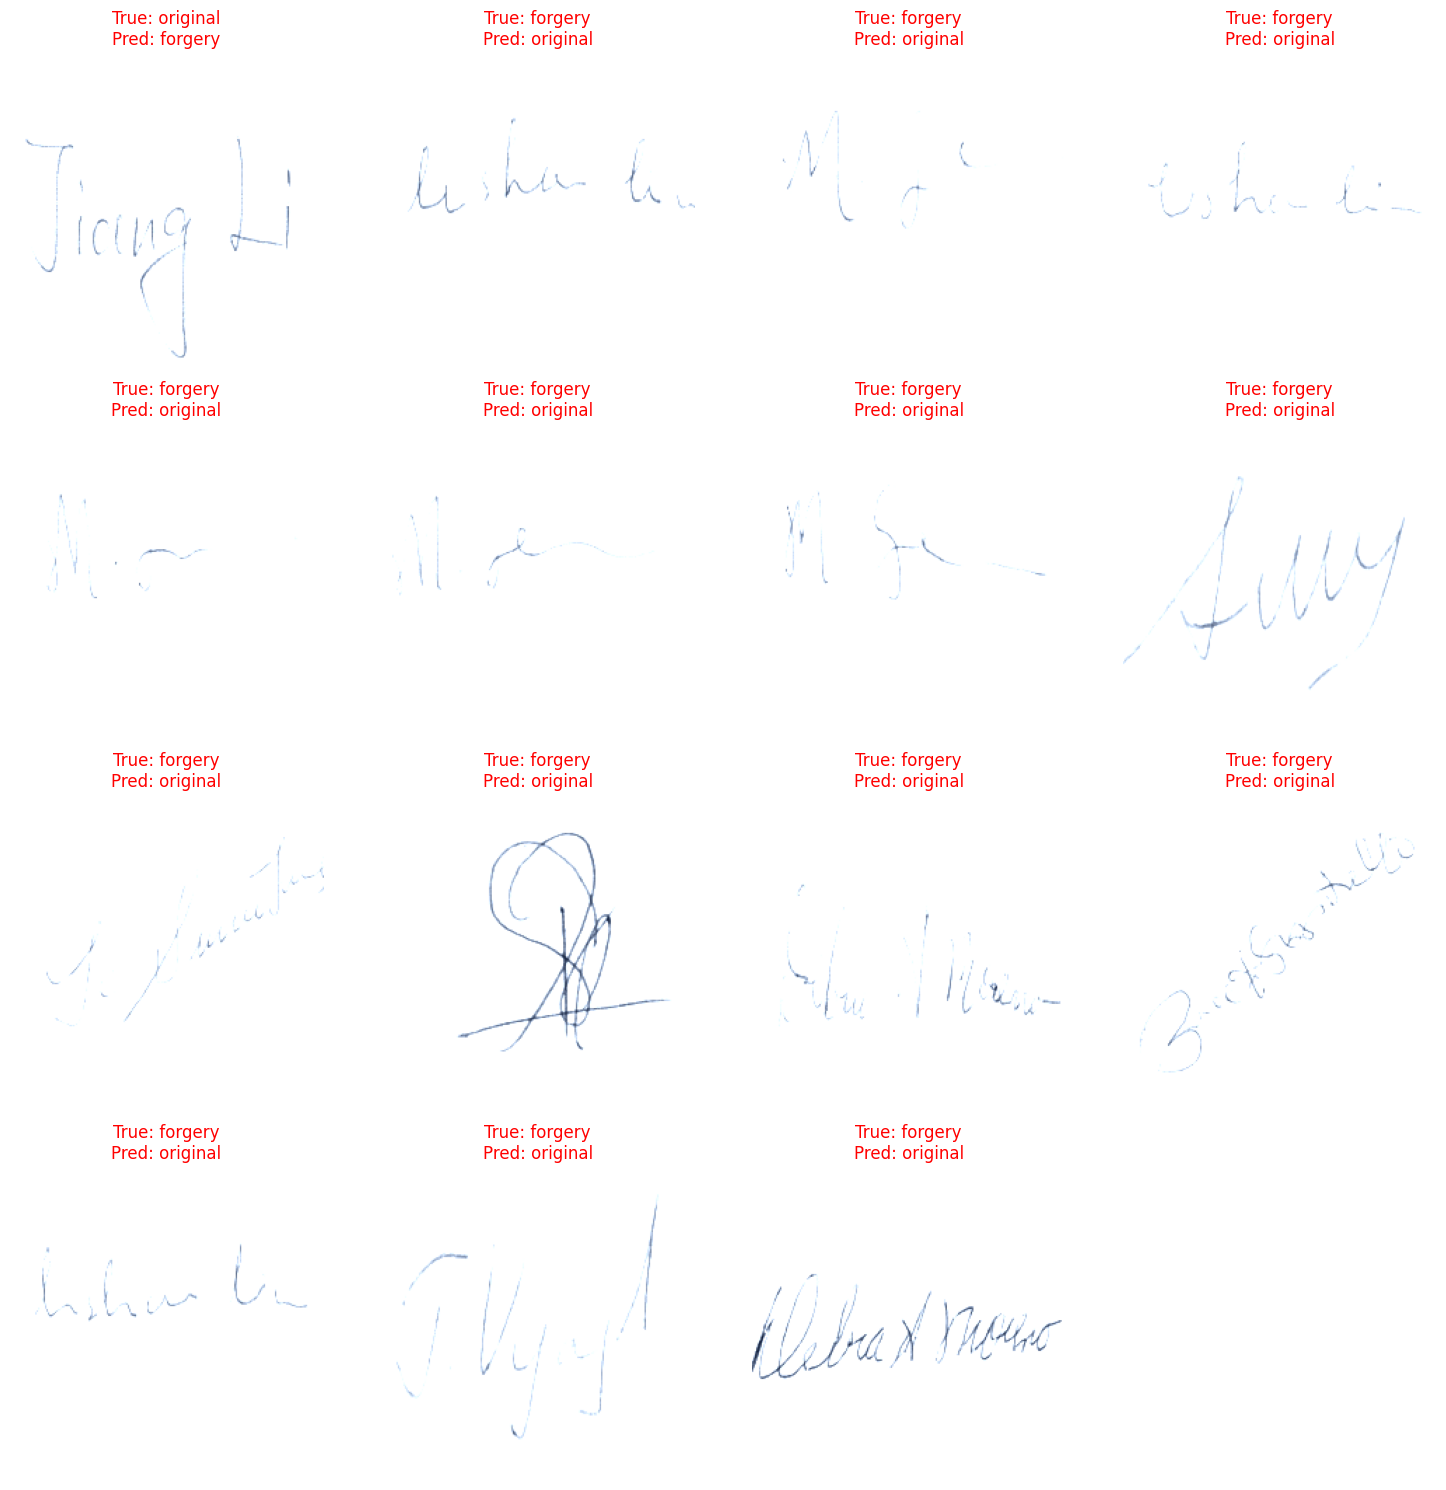

In [ ]:
# Plot misclassified images with ground truth and prediction

plot_misclassified_images(
    model=trained_model,
    dataloader=dataloaders['test'],
    device=device,
    num_images=16,
    class_names=["original", "forgery"],
    mean=config['preprocessing']['image']['mean'],
    std=config['preprocessing']['image']['std']
)

## eXplainability